In [48]:
import argparse

import torch

from accelerate import Accelerator, DeepSpeedPlugin

from accelerate import DistributedDataParallelKwargs

from torch import nn, optim

from torch.optim import lr_scheduler

from tqdm import tqdm



from models import Autoformer, DLinear, TimeLLM



#from data_provider.data_factory import data_provider

import time

import random

import numpy as np

import os



os.environ['CURL_CA_BUNDLE'] = ''

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"



from utils.tools import del_files, EarlyStopping, adjust_learning_rate, vali, load_content


fix_seed = 2021

random.seed(fix_seed)

torch.manual_seed(fix_seed)

np.random.seed(fix_seed)

In [49]:
ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)

deepspeed_plugin = DeepSpeedPlugin(hf_ds_config='./ds_config_zero2.json')

accelerator = Accelerator(kwargs_handlers=[ddp_kwargs], deepspeed_plugin=deepspeed_plugin)

In [50]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from models import TimeLLM
from data_provider.data_factory import data_provider
import time
import torch

In [51]:
class Args:
    def __init__(self):
        self.task_name = 'long_term_forecast'
        self.is_training = 1
        self.model_id = 'Pretrain'
        self.model_comment = 'TimeLLM-Pretrain-13-2500'
        self.model = 'TimeLLM'
        self.seed = 2021
        self.data = 'few_shot_seq'
        self.root_path = './dataset'
        self.data_path = 'combined_dataframes-72.csv'
        self.features = 'MS'
        self.target = 'sold_units'
        self.loader = 'modal'
        self.freq = 'h'
        self.checkpoints = './checkpoints/'
        self.seq_len = 26
        self.label_len = 4
        self.pred_len = 4
        self.seasonal_patterns = 'Monthly'
        self.enc_in = 9
        self.dec_in = 9
        self.c_out = 9
        self.d_model = 32
        self.n_heads = 8  # Typically set by your model configuration
        self.e_layers = 2  # Typically set by your model configuration
        self.d_layers = 1  # Typically set by your model configuration
        self.d_ff = 128
        self.moving_avg = 25  # Assume default if not specified in the script
        self.factor = 3
        self.dropout = 0.1  # Assume default if not specified
        self.embed = 'timeF'  # Assume default if not specified
        self.activation = 'gelu'  # Assume default if not specified
        self.output_attention = False  # Assume default if not specified
        self.patch_len = 16  # Assume default if not specified
        self.stride = 8  # Assume default if not specified
        self.prompt_domain = 0  # Assume default if not specified
        self.llm_model = 'GPT2'
        self.llm_dim = 768
        self.num_workers = 10  # Default setting
        self.itr = 1
        self.train_epochs = 2
        self.align_epochs = 10  # Assume default if not specified
        self.batch_size = 1
        self.eval_batch_size = 8  # Assume default if not specified
        self.patience = 10  # Assume default if not specified
        self.learning_rate = 0.001
        self.des = 'Exp'
        self.loss = 'MSE'  # Assume default if not specified
        self.lradj = 'type1'  # Assume default if not specified
        self.pct_start = 0.2  # Assume default if not specified
        self.use_amp = False  # Assume default based on your environment capabilities
        self.llm_layers = 32
        self.percent = 100  # Assume default if not specified

# Instantiate the Args
args = Args()

In [52]:
combined_dataframes = pd.read_csv('./dataset/combined_dataframes-72.csv')

In [53]:
path = 'checkpoints/long_term_forecast_Pretrain_TimeLLM_ETTh1_ftMS_sl26_ll4_pl4_dm32_nh8_el2_dl1_df128_fc3_ebtimeF_Exp_0-TimeLLM-Pretrain-26-8640/checkpoint'

# Load the checkpoint
model = TimeLLM.Model(args).float()
model.load_state_dict(torch.load(path), strict=False)

<All keys matched successfully>

In [54]:
model.eval()

Model(
  (llm_model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-31): 32 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (padding_patch_layer): ReplicationPad1d()
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(16, 

In [55]:
from data_provider.data_loader import Dataset_few_shot_seq
from torch.utils.data import DataLoader

In [56]:
def data_provider(args, flag, data):
    
    timeenc = 0 if args.embed != 'timeF' else 1
    percent = args.percent

    if flag == 'test' or flag == 'few_shot': # zero shot not few shot
        shuffle_flag = False
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    data_set = Dataset_few_shot_seq(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
        percent=percent,
        seasonal_patterns=args.seasonal_patterns,
        df=data,
        scale = True
    )
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader

In [142]:
product_index = 50

In [143]:
data = combined_dataframes[72*product_index:72*(product_index+1)]

In [144]:
train_data, train_loader = data_provider(args,'few_shot',data=data)

In [145]:
len(train_data)

129

In [146]:
train_data[0][0][0:6]

array([[0.98995559],
       [0.98995559],
       [0.98995559],
       [1.3612429 ],
       [2.10381752],
       [2.10381752]])

In [147]:
data['sold_units'].head(6)

3600    126.0
3601    125.0
3602    216.0
3603    252.0
3604    155.0
3605    144.0
Name: sold_units, dtype: float64

In [148]:
train_data, train_loader = data_provider(args, 'few_shot', data)

vali_data, vali_loader = data_provider(args, 'val', data)

test_data, test_loader = data_provider(args, 'test', data)



time_now = time.time()



train_steps = len(train_loader)

early_stopping = EarlyStopping(accelerator=accelerator, patience=args.patience)



trained_parameters = []

for p in model.parameters():

    if p.requires_grad is True:

        trained_parameters.append(p)



model_optim = optim.Adam(trained_parameters, lr=args.learning_rate)



if args.lradj == 'COS':

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_optim, T_max=20, eta_min=1e-8)

else:

    scheduler = lr_scheduler.OneCycleLR(optimizer=model_optim,

                                        steps_per_epoch=train_steps,

                                        pct_start=args.pct_start,

                                        epochs=args.train_epochs,

                                        max_lr=args.learning_rate)



train_loader, vali_loader, test_loader, model, model_optim, scheduler = accelerator.prepare(

        train_loader, vali_loader, test_loader, model, model_optim, scheduler)

In [149]:
criterion = nn.MSELoss()
mae_metric = nn.L1Loss()

In [150]:
y = list()
for i in range(len(train_data)):
    y.append(train_data[i][1][args.label_len].item())

In [151]:
np.array(y).shape

(129,)

In [152]:
variable_splits = np.split(np.array(y), 3, axis=0)

In [153]:
variable_splits[0]

array([ 0.09886604, -0.56945112, -0.56945112, -0.56945112, -0.68083731,
       -0.79222351, -0.79222351, -0.79222351, -0.73653041, -0.68083731,
       -0.68083731, -0.68083731,  0.04317294,  0.7671832 ,  0.7671832 ,
        0.7671832 , -0.29098564, -1.34915447, -1.34915447, -1.34915447,
       -1.34915447, -1.34915447, -1.68331305, -2.01747163, -2.01747163,
       -2.01747163, -1.79469925, -1.57192686, -1.57192686, -1.57192686,
       -0.45806493,  0.65579701,  0.65579701,  0.65579701, -0.45806493,
       -1.57192686, -1.57192686, -1.57192686, -1.57192686, -1.57192686,
       -1.07068899, -0.56945112, -0.56945112])

In [154]:
y_réel = np.array(y).reshape(3,-1).T* train_data.std + train_data.mean
y_réel[:,0]

array([7.9 , 7.3 , 7.3 , 7.3 , 7.2 , 7.1 , 7.1 , 7.1 , 7.15, 7.2 , 7.2 ,
       7.2 , 7.85, 8.5 , 8.5 , 8.5 , 7.55, 6.6 , 6.6 , 6.6 , 6.6 , 6.6 ,
       6.3 , 6.  , 6.  , 6.  , 6.2 , 6.4 , 6.4 , 6.4 , 7.4 , 8.4 , 8.4 ,
       8.4 , 7.4 , 6.4 , 6.4 , 6.4 , 6.4 , 6.4 , 6.85, 7.3 , 7.3 ])

In [155]:
data["sold_units"].iloc[26:72-4]

3626     71.0
3627     84.0
3628    121.0
3629    135.0
3630     82.0
3631     63.0
3632     82.0
3633     92.0
3634     90.0
3635     63.0
3636     98.0
3637     86.0
3638     74.0
3639     78.0
3640     75.0
3641     82.0
3642     77.0
3643     75.0
3644     76.0
3645     86.0
3646     95.0
3647    113.0
3648     83.0
3649     59.0
3650    155.0
3651    242.0
3652    340.0
3653     90.0
3654    180.0
3655    423.0
3656    185.0
3657    276.0
3658    178.0
3659     80.0
3660    175.0
3661     78.0
3662     94.0
3663     98.0
3664     97.0
3665    106.0
3666     81.0
3667    108.0
Name: sold_units, dtype: float64

In [156]:
from torch.cuda.amp import autocast, GradScaler

# Setup scaler for managing precision
scaler = GradScaler()
MSE_loss = list()
MAE_loss = list()
predictions = list()
true_labels = list()
with torch.no_grad():  # No need to compute gradients during inference
    train_loss_mse = list()
    train_loss_mae = list()
    for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
        batch_x = batch_x.float().to(accelerator.device)
        batch_y = batch_y.float().to(accelerator.device)
        batch_x_mark = batch_x_mark.float().to(accelerator.device)
        batch_y_mark = batch_y_mark.float().to(accelerator.device)

        # Prepare decoder input as zeros initially, similar to training phase setup
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).to(accelerator.device)
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1)
        
        # Using autocast for automatic mixed precision
        with autocast():
            if args.output_attention:
                output, _ = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            else:
                output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

            output = output[:, -args.pred_len:, :]  # Adjust based on the output dimensions if needed
        loss = criterion(output, batch_y[:, -args.pred_len:, :])
        train_loss_mse.append(loss.item())
        loss = mae_metric(output, batch_y[:, -args.pred_len:, :])
        train_loss_mae.append(loss.item())
    
        predictions.append(output.cpu().numpy())
        true_labels.append(batch_y[:, -args.pred_len:, :].cpu().numpy())
    
# Convert list of arrays to a single numpy array
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
MAE_loss.append(np.average(train_loss_mae))
MSE_loss.append(np.average(train_loss_mse))


In [157]:
MAE_loss, MSE_loss

([0.8362809102549109], [1.7806542373240688])

In [158]:
train_data[100][1], true_labels[100]

(array([[ 0.09343592],
        [-0.21170923],
        [-0.51685438],
        [-0.41513933],
        [-0.49142562],
        [-0.31342428],
        [-0.4405681 ],
        [-0.49142562]]),
 array([[-0.49142563],
        [-0.3134243 ],
        [-0.4405681 ],
        [-0.49142563]], dtype=float32))

In [159]:
predictions.shape

(129, 4, 1)

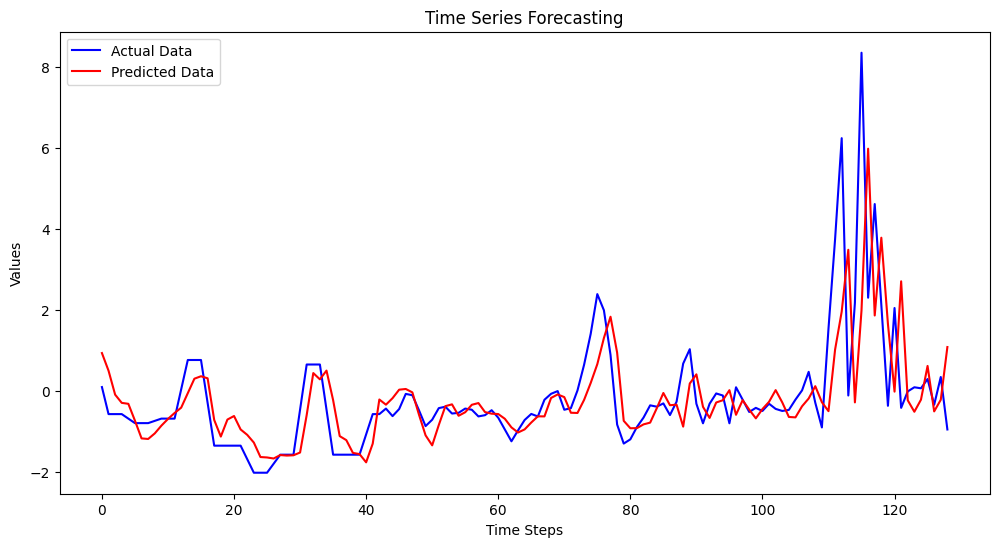

In [160]:
import matplotlib.pyplot as plt
%matplotlib inline
# Assuming predictions and true_labels are numpy arrays of the same shape
plt.figure(figsize=(12, 6))
plt.plot(true_labels[:, 0], label='Actual Data', color='blue')  # Adjust indexing based on your data shape
plt.plot(predictions[:, 0], label='Predicted Data', color='red')  # Adjust indexing based on your data shape
plt.title('Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

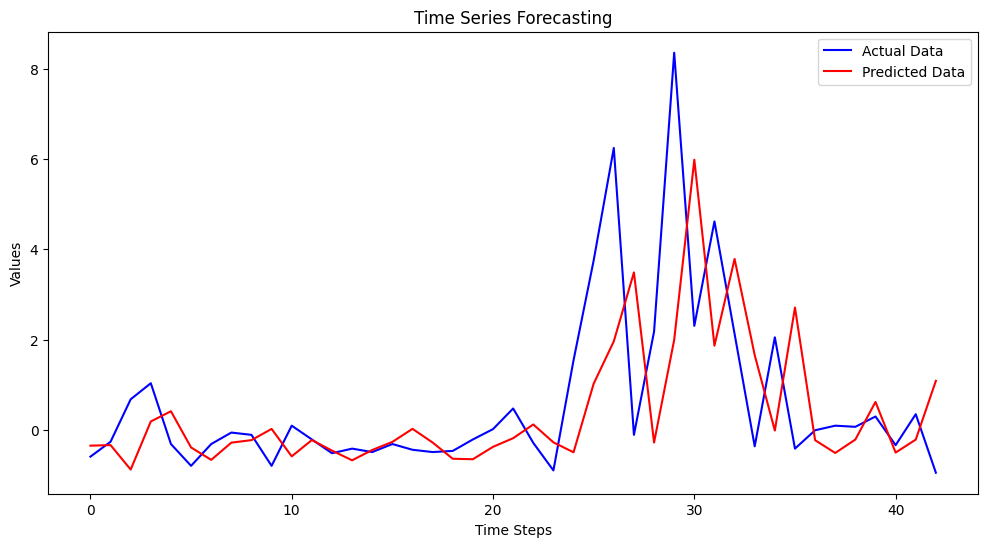

In [161]:
import matplotlib.pyplot as plt
%matplotlib inline
# Assuming predictions and true_labels are numpy arrays of the same shape
plt.figure(figsize=(12, 6))
plt.plot(true_labels[43*2:, 0], label='Actual Data', color='blue')  # Adjust indexing based on your data shape
plt.plot(predictions[43*2:, 0], label='Predicted Data', color='red')  # Adjust indexing based on your data shape
plt.title('Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

# Scaling

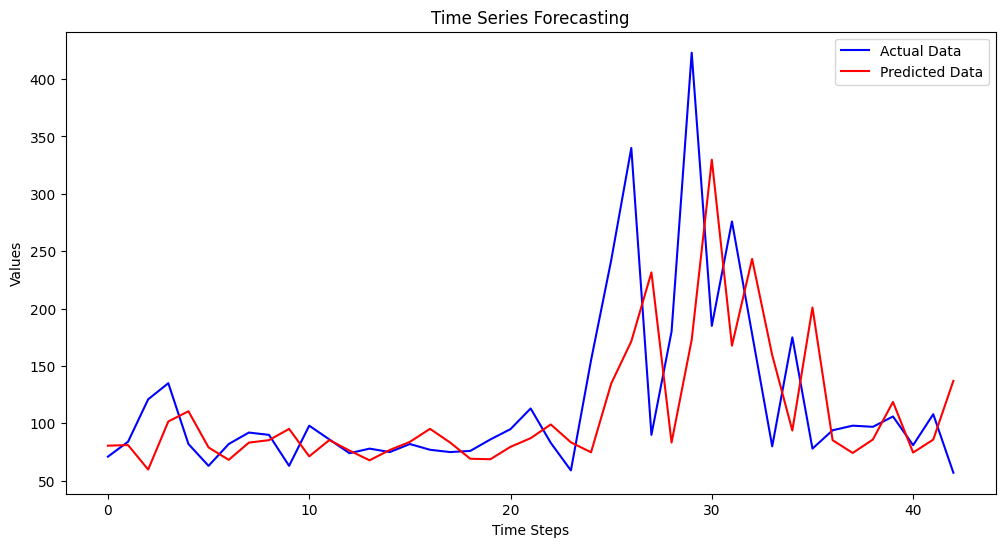

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
# Assuming predictions and true_labels are numpy arrays of the same shape
plt.figure(figsize=(12, 6))
plt.plot(true_labels[43*2:, 0]*train_data.std[2] + train_data.mean[2], label='Actual Data', color='blue')  # Adjust indexing based on your data shape
plt.plot(predictions[43*2:, 0]*train_data.std[2] + train_data.mean[2], label='Predicted Data', color='red')  # Adjust indexing based on your data shape
plt.title('Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()